In [1]:
from pathlib import Path
import json
import csv
import pandas as pd
import numpy as np

In [2]:
# global flags
generate_graphs = False

# Data Gathering
 - Gather json files into csv files

In [3]:
def gather_json(directory, typ):
    with (directory / 'data.csv').open('w') as csvfile:
        wr = csv.writer(csvfile, delimiter=',')
        wr.writerow(['benchmark', 'type', 'key', 'value'])

        for bench in directory.glob("*.json"):
            benchname = bench.stem
            if 'linear-algebra' in str(bench):
                benchname = bench.stem.split('-')[2]
            try:
                for key, value in json.load(bench.open()).items():
                    wr.writerow([benchname, typ, key, value])
            except json.JSONDecodeError as e:
                print(f"{bench} decode error: {e}")

In [4]:
# polybench standard
gather_json(Path("../results/standard/hls/"), 'hls')
gather_json(Path("../results/standard/futil/"), 'futil')
gather_json(Path("../results/standard/futil-latency/"), 'futil')

# polybench unrolled
gather_json(Path("../results/unrolled/hls/"), 'hls-unrolled')
gather_json(Path("../results/unrolled/futil/"), 'futil-unrolled')
gather_json(Path("../results/unrolled/futil-latency/"), 'futil-unrolled')

# systolic
gather_json(Path("../results/systolic/hls/"), 'systolic-hls')
gather_json(Path("../results/systolic/futil/"), 'systolic-futil')
gather_json(Path("../results/systolic/futil-latency/"), 'systolic-futil')

# latency sensitive
gather_json(Path("../results/latency-sensitive/no-static-timing/"), 'no-static-timing')
gather_json(Path("../results/latency-sensitive/with-static-timing/"), 'with-static-timing')

# optimizations
gather_json(Path("../results/opts/all/"), 'all')
gather_json(Path("../results/opts/minimize-regs/"), 'minimize-regs')
gather_json(Path("../results/opts/resource-sharing/"), 'resource-sharing')
gather_json(Path("../results/opts/none/"), 'none')
gather_json(Path("../results/opts/all-unrolled/"), 'all-unrolled')
gather_json(Path("../results/opts/minimize-regs-unrolled/"), 'minimize-regs-unrolled')
gather_json(Path("../results/opts/resource-sharing-unrolled/"), 'resource-sharing-unrolled')
gather_json(Path("../results/opts/none-unrolled/"), 'none-unrolled')

# Pandas data processing

## Gather Data + Cleanup
 - Throwaway keys irrelevant for the figures and do renaming

In [5]:
def cleanup(df, rename, include):
    # rename
    for (key_name, key), v in rename.items():
        df.loc[df[key_name] == key, key_name] = v

    # only keep things in include
    return df[df['key'].isin(include)].reset_index(drop=True)

# polybench data
standard_hls = pd.read_csv("../results/standard/hls/data.csv")
standard_futil = pd.read_csv("../results/standard/futil/data.csv")
standard_futil_lat = pd.read_csv("../results/standard/futil-latency/data.csv")
unrolled_hls = pd.read_csv("../results/unrolled/hls/data.csv")
unrolled_futil = pd.read_csv("../results/unrolled/futil/data.csv")
unrolled_futil_lat = pd.read_csv("../results/unrolled/futil-latency/data.csv")
polybench_raw = standard_hls.append(standard_futil).append(standard_futil_lat).append(unrolled_hls).append(unrolled_futil).append(unrolled_futil_lat).reset_index(drop=True)
polybench = cleanup(polybench_raw, {
    ('key', 'avg_latency'): 'latency',
}, ['dsp', 'lut', 'latency'])

# systolic data
hls = pd.read_csv("../results/systolic/hls/data.csv")
futil = pd.read_csv("../results/systolic/futil/data.csv")
futil_lat = pd.read_csv("../results/systolic/futil-latency/data.csv")
systolic_raw = hls.append(futil).append(futil_lat).reset_index(drop=True)
systolic = cleanup(systolic_raw, {
    ('key', 'avg_latency'): 'latency',
    ('benchmark', 'gemm2'): '2 x 2',
    ('benchmark', 'gemm4'): '4 x 4',
    ('benchmark', 'gemm6'): '6 x 6',
    ('benchmark', 'gemm8'): '8 x 8',
}, ['dsp', 'lut', 'latency'])

# latency insensitive data
with_static_timing = pd.read_csv('../results/latency-sensitive/with-static-timing/data.csv')
no_static_timing = pd.read_csv('../results/latency-sensitive/no-static-timing/data.csv')
latency_sensitive_raw = with_static_timing.append(no_static_timing).reset_index(drop=True)
latency_sensitive = cleanup(latency_sensitive_raw, {}, ['latency'])

# opts
opts_all = pd.read_csv('../results/opts/all/data.csv')
opts_mr = pd.read_csv('../results/opts/minimize-regs/data.csv')
opts_rs = pd.read_csv('../results/opts/resource-sharing/data.csv')
opts_none = pd.read_csv('../results/opts/none/data.csv')
opts_std = opts_all.append(opts_mr).append(opts_rs).append(opts_none)
opts_all = pd.read_csv('../results/opts/all-unrolled/data.csv')
opts_mr = pd.read_csv('../results/opts/minimize-regs-unrolled/data.csv')
opts_rs = pd.read_csv('../results/opts/resource-sharing-unrolled/data.csv')
opts_none = pd.read_csv('../results/opts/none-unrolled/data.csv')
opts_ur = opts_all.append(opts_mr).append(opts_rs).append(opts_none)
opts = opts_std.append(opts_ur).reset_index(drop=True)

## Calculate norms 

In [6]:
def match(df, benchmark, typ):
    return df[(df['benchmark'] == benchmark) & (df['type'] == typ)]

def _row_math(df, top_key, bot_key, name, op):
    df = df.copy()
    for bench in df['benchmark'].unique():
        norm = match(df, bench, top_key).copy()
        top = match(df, bench, top_key)['value']
        bot = match(df, bench, bot_key)['value']
        if len(top.values) == len(bot.values):
            norm['value'] = op(top.values,bot.values)
            norm['type'] = name
            df = df.append(norm)
    return df

def norm(df, top_key, bot_key, name):
    return _row_math(df, top_key, bot_key, name, lambda a, b: a / b)

        
polybench = norm(polybench, 'futil', 'hls', 'norm')
polybench = norm(polybench, 'futil-unrolled', 'hls-unrolled', 'norm-unrolled')
latency_sensitive = norm(latency_sensitive, 'with-static-timing', 'no-static-timing', 'norm')
opts = norm(opts, 'minimize-regs', 'none', 'minimize-regs-norm')
opts = norm(opts, 'resource-sharing', 'none', 'resource-sharing-norm')
opts = norm(opts, 'all', 'none', 'all-norm')
opts = _row_math(opts, 'none', 'minimize-regs', 'mr-diff', lambda a, b: b - a)
opts = _row_math(opts, 'none', 'resource-sharing', 'rs-diff', lambda a, b: b - a)
opts = _row_math(opts, 'none', 'all', 'all-diff', lambda a, b: b - a)

<ipython-input-6-0c21962cf13b>:17: RuntimeWarning: invalid value encountered in true_divide
  return _row_math(df, top_key, bot_key, name, lambda a, b: a / b)


## Dataframe formatting
 - Transition from long-form to short-form data by using `pivot`.
 - Reorder table so that unrolled benchmarks are grouped at the beginning

In [7]:
def pivot_and_order(df, order):
    df = df.pivot(index=['benchmark', 'type'], columns='key', values='value').reset_index()
    df['benchmark'] = pd.Categorical(df['benchmark'], order)
    return df

polybench_order = [
    '2mm', '3mm', 'atax','doitgen','gemm',
    'gemver','gesummv','gramschmidt','mvt',
    'syr2k', 'syrk','bicg','cholesky','durbin',
    'lu','ludcmp','symm','trisolv', 'trmm'
]

polybench = pivot_and_order(polybench, polybench_order)

systolic = pivot_and_order(systolic, [
    '2 x 2', 
    '4 x 4',
    '6 x 6',
    '8 x 8'
])

latency_sensitive = pivot_and_order(latency_sensitive, polybench_order)
opts = pivot_and_order(opts, polybench_order)

## Helpers

In [8]:
def apply_legend(df, name, legend):
    df = df.copy()
    df[name] = df[name].apply(lambda x: legend[x])
    return df

# Graph Generation

## 5a. Systolic Array Normalized cycle counts

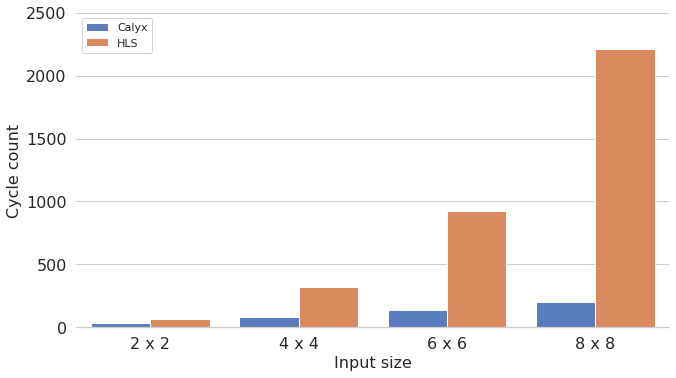

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'systolic-futil': 'Calyx',
    'systolic-hls': 'HLS'
}
g = sns.catplot(
    x="benchmark", 
    y="latency", 
    hue="type", 
    data=apply_legend(systolic, 'type', legend),
    kind="bar", 
    palette="muted",
    legend=False,
    log=False
)
g.despine(left=True)
g.set_ylabels("Cycle count", fontsize=16)
g.set_xlabels("Input size", fontsize=16)
g.set_yticklabels(fontsize=16)
g.set_xticklabels(fontsize=16)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('systolic-lat.pdf')

## 5b. Systolic Array Normalized LUT usage

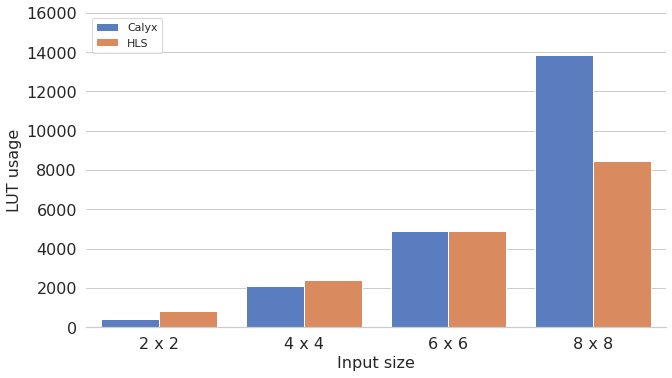

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'systolic-futil': 'Calyx',
    'systolic-hls': 'HLS'
}
g = sns.catplot(
    x="benchmark", 
    y="lut", 
    hue="type", 
    data=apply_legend(systolic, 'type', legend),
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("LUT usage", fontsize=16)
g.set_xlabels("Input size", fontsize=16)
g.set_yticklabels(fontsize=16)
g.set_xticklabels(fontsize=16)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('systolic-lut.pdf')

## 6a. Cycle counts normalized to Vivado HLS

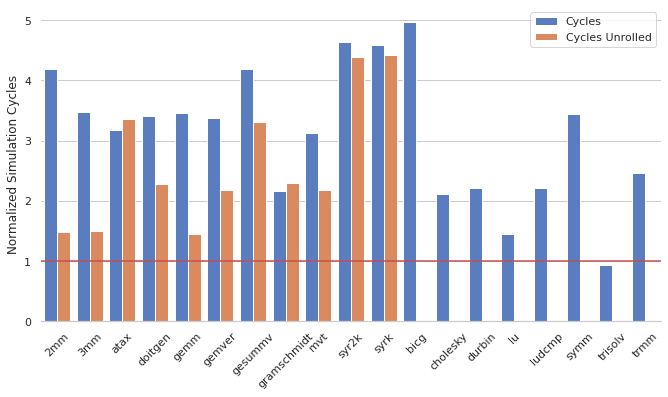

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'norm': 'Cycles',
    'norm-unrolled': 'Cycles Unrolled'
}

df = polybench[polybench['type'].isin(['norm', 'norm-unrolled'])]
g = sns.catplot(
    x="benchmark",
    y="latency",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('unrolled-lat-sen-cycles.pdf')

## 6b. LUT usage normalized to Vivado HLS

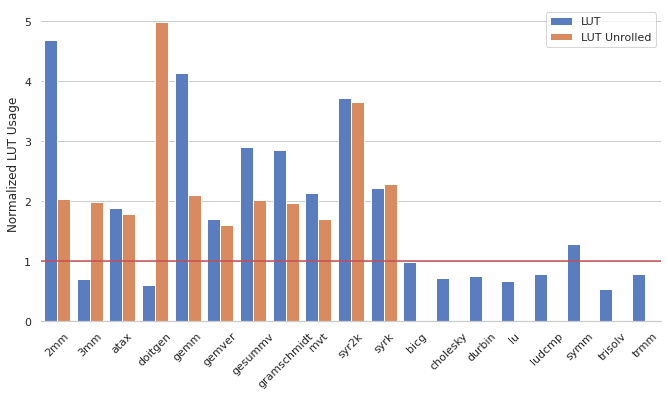

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'norm': 'LUT',
    'norm-unrolled': 'LUT Unrolled'
}

df = polybench[polybench['type'].isin(['norm', 'norm-unrolled'])]
g = sns.catplot(
    x="benchmark",
    y="lut",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized LUT Usage")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('unrolled-lat-sen-lut.pdf')

## 6c. Cycle counts normalized to latency-insensitive design 

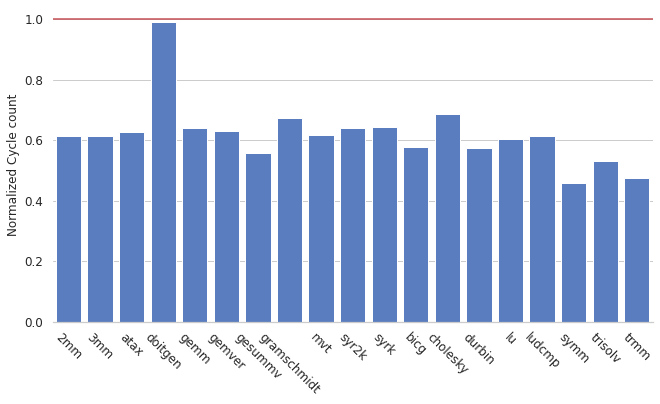

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df = latency_sensitive
g = sns.catplot(
    x="benchmark", 
    y="latency",
    hue="type",
    data=df[df['type'] == 'norm'],
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Cycle count", fontsize=12)
g.set_xlabels("")
g.set_xticklabels(rotation=-45, fontsize=12)
g.fig.set_size_inches(10,5)

g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(12) # I hate this, but otherwise the axes would be wrong

if generate_graphs:
    g.savefig('norm-lat-sen-insen.pdf', dpi=400)

# Optimizations

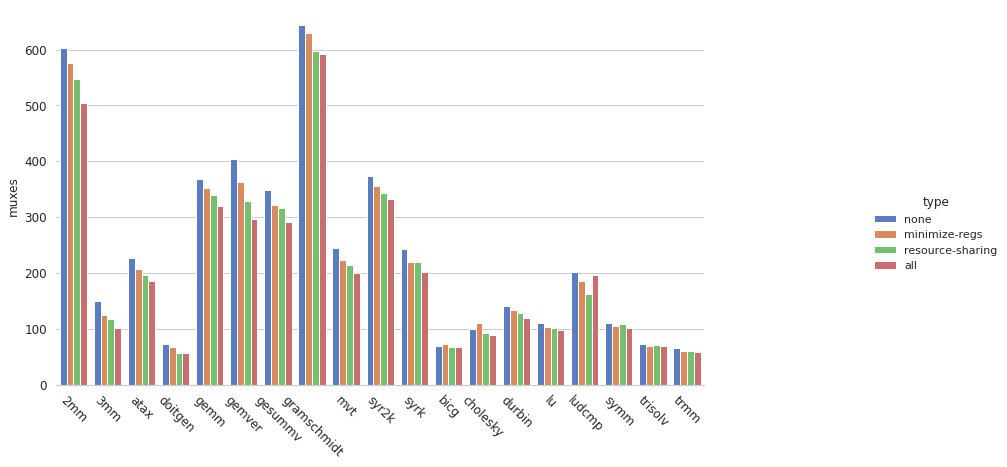

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df = opts
g = sns.catplot(
    x="benchmark", 
    y="muxes",
    hue="type",
    data=df,
    kind="bar", 
    palette="muted",
    legend=True,
    hue_order=map(lambda x: f"{x}", ['none', 'minimize-regs', 'resource-sharing', 'all'])
)
g.despine(left=True)
# g.set_ylabels("Normalized Cycle count", fontsize=12)
g.set_xlabels("")
g.set_xticklabels(rotation=-45, fontsize=12)
g.fig.set_size_inches(15,6)

# g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(12) # I hate this, but otherwise the axes would be wrong


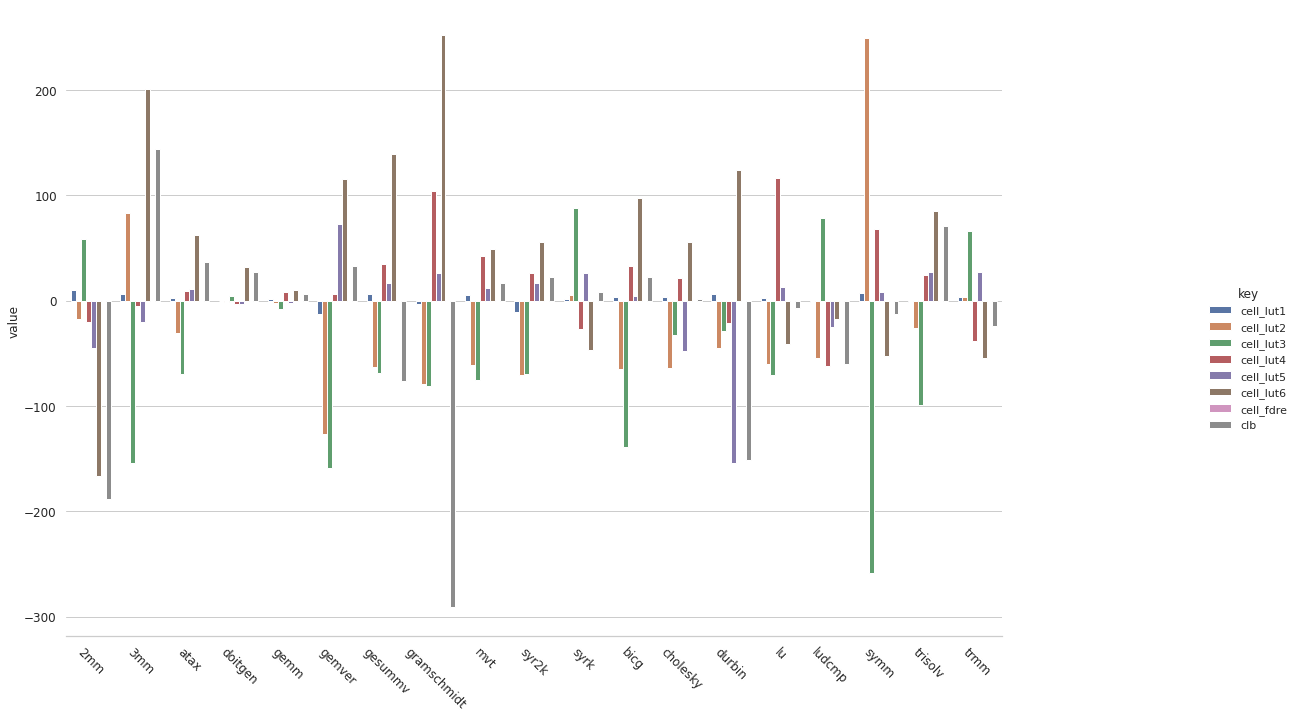

In [31]:
df = opts[opts['type'] == 'rs-diff'].reset_index(drop=True)
cells = list(map(lambda x: f"cell_lut{x}", range(1,7))) + ['cell_fdre', 'clb']
df = df[['benchmark'] + cells].melt(id_vars=['benchmark'])
g = sns.catplot(
    x='benchmark',
    y='value',
    hue='key',
    kind='bar',
    data=df
)
g.despine(left=True)
# g.set_ylabels("Normalized Cycle count", fontsize=12)
g.set_xlabels("")
g.set_xticklabels(rotation=-45, fontsize=12)
g.fig.set_size_inches(20,10)

# g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(12) # I hate this, but otherwise the axes would be wrong


In [16]:
opts

key,benchmark,type,carry8,cell_fdre,cell_lut1,cell_lut2,cell_lut3,cell_lut4,cell_lut5,cell_lut6,clb,clb_registers,dsp,f7_muxes,f8_muxes,f9_muxes,lut,meet_timing,muxes,registers
0,NaN,minimize-regs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,373.000000,1.0,70.000000,40.000000
1,2mm,all,12.00,10748.000000,9.0,261.000000,202.000000,332.000000,179.000000,3501.000000,16666.000000,10748.000000,12.0,1280.0,504.0000,0.0,4122.000000,1.0,504.000000,431.000000
2,2mm,all-diff,-4.00,-547.000000,10.0,-4.000000,-23.000000,126.000000,36.000000,66.000000,-543.000000,-547.000000,0.0,0.0,-136.0000,0.0,144.000000,0.0,-99.000000,-46.000000
3,2mm,all-norm,0.75,0.951571,-9.0,0.984906,0.897778,1.611650,1.251748,1.019214,0.968447,0.951571,1.0,1.0,0.7875,NaN,1.036199,1.0,0.835821,0.903564
4,2mm,all-unrolled,88.00,13904.000000,3.0,857.000000,1891.000000,1099.000000,614.000000,4372.000000,23190.000000,13904.000000,84.0,1268.0,570.0000,0.0,7360.000000,1.0,1224.000000,940.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,trmm,mr-diff,0.00,-64.000000,4.0,8.000000,5.000000,62.000000,0.000000,-4.000000,-1.000000,-64.000000,0.0,0.0,0.0000,0.0,63.000000,0.0,-4.000000,-4.000000
231,trmm,none,8.00,367.000000,-1.0,79.000000,106.000000,51.000000,27.000000,108.000000,656.000000,367.000000,6.0,0.0,0.0000,0.0,281.000000,1.0,65.000000,50.000000
232,trmm,resource-sharing,8.00,367.000000,2.0,82.000000,172.000000,13.000000,54.000000,53.000000,632.000000,367.000000,6.0,0.0,0.0000,0.0,257.000000,1.0,61.000000,50.000000
233,trmm,resource-sharing-norm,1.00,1.000000,-2.0,1.037975,1.622642,0.254902,2.000000,0.490741,0.963415,1.000000,1.0,NaN,NaN,NaN,0.914591,1.0,0.938462,1.000000


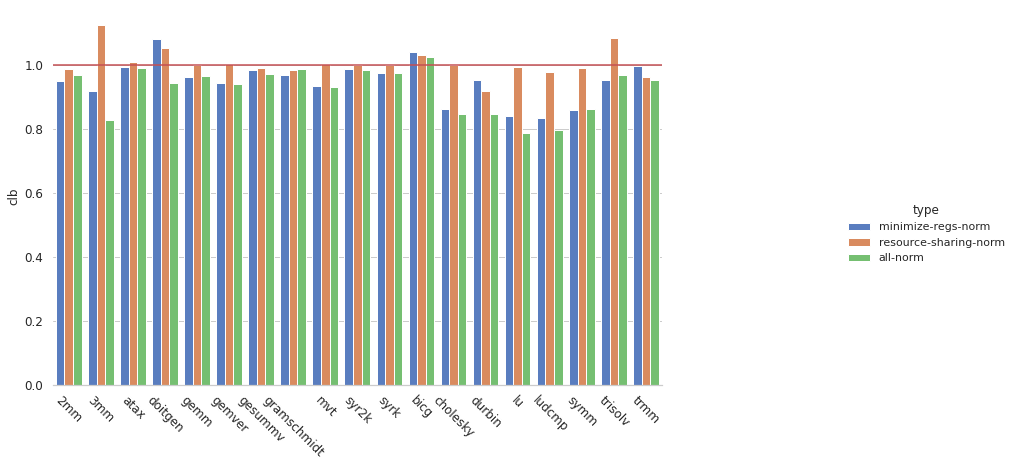

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df = opts
g = sns.catplot(
    x="benchmark", 
    y="clb",
    hue="type",
    data=df,
    kind="bar", 
    palette="muted",
    legend=True,
    hue_order=map(lambda x: f"{x}-norm", ['minimize-regs', 'resource-sharing', 'all'])
)
g.despine(left=True)
# g.set_ylabels("Normalized Cycle count", fontsize=12)
g.set_xlabels("")
g.set_xticklabels(rotation=-45, fontsize=12)
g.fig.set_size_inches(15,6)

g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(12) # I hate this, but otherwise the axes would be wrong
